# Testing with different probabilities in the loop
for this let's take 400 terms and run it via mixed strategy of LO & RI

In [1]:
import random
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions
from deap import tools, base, creator
import seaborn as sns

sys.path.append("../")
from calculus.term import *
from calculus.strategy import *
from calculus.generation import *
from calculus.generation_threading import *

from calculus_utils.drawing import *
from calculus_utils.algorithms import *
from calculus_utils.outliers_cleaning import clear_arr

from vd_env.lambda_env import LambdaEnv
from vd_env.run_greedy_policy import run_greedy_policy
from vd_env.run_e_greedy_policy import run_e_greedy_policy

In [2]:
RANDOM_AVERAGE_COUNT = 20

terms, stepsLO = gen_filtered_lambda_terms_v2(count_terms=400)
stepsRI = [term.normalize(RightmostInnermostStrategy())[1] for term in tqdm(terms)]
stepsRand = [
    sum(term.normalize(RandomStrategy())[1] for i in range(RANDOM_AVERAGE_COUNT))
    / RANDOM_AVERAGE_COUNT
    for term in tqdm(terms)
]

100%|██████████| 400/400 [00:47<00:00,  8.43it/s]


In [4]:
from contextlib import contextmanager
import threading
import _thread


class TimeoutException(Exception):
    def __init__(self, msg=''):
        self.msg = msg


@contextmanager
def time_limit(seconds, msg=''):
    timer = threading.Timer(seconds, lambda: _thread.interrupt_main())
    timer.start()
    try:
        yield
    except KeyboardInterrupt:
        raise TimeoutException("Timed out for operation {}".format(msg))
    finally:
        # if the action ends in specified time, timer is canceled
        timer.cancel()

In [5]:
steps_mixed_all = []
expected_values = []
values = list(range(0, 101, 5))
iters = len(values) - 1

for inx, p_lo in enumerate(values):
    p = (p_lo / 100, 1 - p_lo / 100)
    steps = []
    for term in tqdm(terms, desc=f"it {inx} / {iters}"):
        term_random_steps = []
        for i in range(RANDOM_AVERAGE_COUNT):
            trs = 0
            try:
                with time_limit(15, "do norm"):
                    trs = term.normalize(MixedStrategy([LeftmostOutermostStrategy(), RightmostInnermostStrategy()], p))[1]
            except TimeoutException:
                trs = float("inf")
            term_random_steps.append(trs)
        steps.append(sum(term_random_steps) / RANDOM_AVERAGE_COUNT)

    steps_mixed_all.append(steps)


it 0 / 20: 100%|██████████| 400/400 [13:30<00:00,  2.03s/it]

it 1 / 20: 100%|██████████| 400/400 [06:27<00:00,  1.03it/s]

it 2 / 20: 100%|██████████| 400/400 [01:59<00:00,  3.36it/s]

it 3 / 20: 100%|██████████| 400/400 [00:53<00:00,  7.44it/s]

it 4 / 20: 100%|██████████| 400/400 [00:32<00:00, 12.42it/s]

it 5 / 20: 100%|██████████| 400/400 [00:23<00:00, 16.90it/s]

it 6 / 20: 100%|██████████| 400/400 [00:21<00:00, 18.81it/s]

it 7 / 20: 100%|██████████| 400/400 [00:21<00:00, 18.95it/s]

it 8 / 20: 100%|██████████| 400/400 [00:21<00:00, 18.96it/s]

it 9 / 20: 100%|██████████| 400/400 [00:22<00:00, 17.89it/s]

it 10 / 20: 100%|██████████| 400/400 [00:22<00:00, 17.76it/s]

it 11 / 20: 100%|██████████| 400/400 [00:22<00:00, 17.61it/s]

it 12 / 20: 100%|██████████| 400/400 [00:23<00:00, 16.81it/s]

it 13 / 20: 100%|██████████| 400/400 [00:23<00:00, 16.68it/s]

it 14 / 20: 100%|██████████| 400/400 [00:24<00:00, 16.56it/s]

it 15 / 20: 100%|██████████| 400/400 [00:22<00:00, 17.41it/s]

i

In [6]:
print(len(steps_mixed_all))

21


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 31.68it/s]


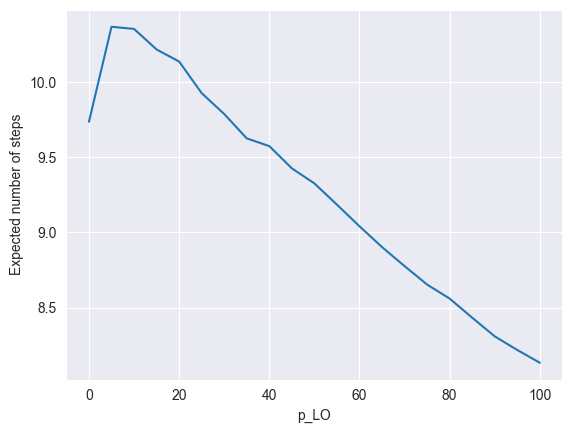

In [13]:
expected_values = []
for steps in steps_mixed_all:
    steps = list(filter(lambda x: x != float("inf"), steps))
    steps = list(filter(lambda x: x != 0, steps))

    distributions = get_common_distributions()
    distributions.remove("expon")
    f_ln = Fitter([np.log(step) for step in steps], distributions=distributions)
    f_ln.fit()

    mu, sigma = f_ln.fitted_param["norm"]
    result = np.e ** (mu + (sigma ** 2) / 2)
    expected_values.append(result)

plt.plot(values, expected_values)
plt.xlabel("p_LO")
plt.ylabel("Expected number of steps")
plt.show()

In [14]:
inx_best = expected_values.index(min(expected_values))

In [15]:
print(inx_best)

20


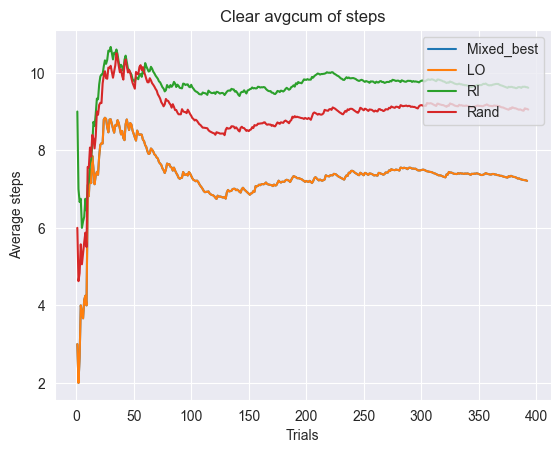

In [16]:
comp_data = {
    "Mixed_best": (clear_arr(steps_mixed_all[inx_best]), "-"),
    "LO": (clear_arr(stepsLO), "-"),
    "RI": (clear_arr(stepsRI), "-"),
    "Rand": (clear_arr(stepsRand), "-"),
}
draw_cumulative_avg_comparison(comp_data, title=f"Clear avgcum of steps")

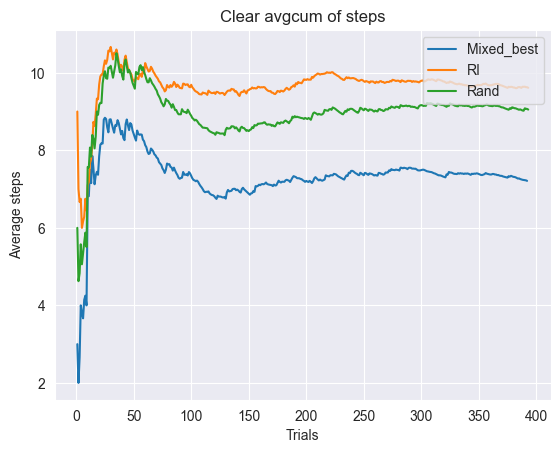

In [17]:
comp_data = {
    "Mixed_best": (clear_arr(steps_mixed_all[inx_best]), "-"),
    # "LO": (clear_arr(stepsLO), "-"),
    "RI": (clear_arr(stepsRI), "-"),
    "Rand": (clear_arr(stepsRand), "-"),
}
draw_cumulative_avg_comparison(comp_data, title=f"Clear avgcum of steps")

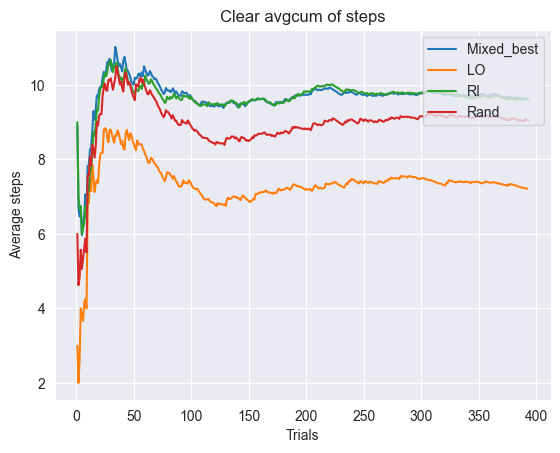

In [18]:
comp_data = {
    "Mixed_best": (clear_arr(steps_mixed_all[1]), "-"),
    "LO": (clear_arr(stepsLO), "-"),
    "RI": (clear_arr(stepsRI), "-"),
    "Rand": (clear_arr(stepsRand), "-"),
}
draw_cumulative_avg_comparison(comp_data, title=f"Clear avgcum of steps")

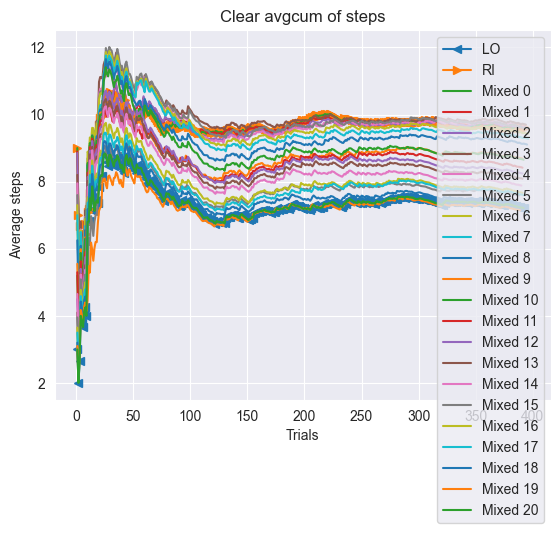

In [19]:
comp_data = {
    "LO": (clear_arr(stepsLO), "-<"),
    "RI": (clear_arr(stepsRI), "->"),
}

for inx, steps in enumerate(steps_mixed_all):
    comp_data[f"Mixed {inx}"] = (clear_arr(steps), "-")

draw_cumulative_avg_comparison(comp_data, title=f"Clear avgcum of steps")